In [1]:
import numpy as np
import pandas
import pandas as pd
import os
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
#from sklearn.decomposition import PCA
#from sklearn.cluster import KMeans

inline_rc = dict(mpl.rcParams)

In [2]:
# CARGAMOS LOS DATOS DE LAS REVIEWS
df_review = pd.read_csv('data/yelp_reviews.csv')
df_review = pd.DataFrame(df_review)
print(df_review)

                 business_id        date               review_id  stars  \
0     9yKzy9PApeiPPOUJEtnvkg  2011-01-26  fWKvX83p0-ka4JS3dc6E5A      5   
1     ZRJwVLyzEJq1VAihDhYiow  2011-07-27  IjZ33sJrzXqU-0X6U8NwyA      5   
2     6oRAC4uyJCsJl1X0WZpVSA  2012-06-14  IESLBzqUCLdSzSqm0eCSxQ      4   
3     _1QQZuf4zZOyFCvXc0o6Vg  2010-05-27  G-WvGaISbqqaMHlNnByodA      5   
4     6ozycU1RpktNG2-1BroVtw  2012-01-05  1uJFq2r5QfJG_6ExMRCaGw      5   
...                      ...         ...                     ...    ...   
9995  VY_tvNUCCXGXQeSvJl757Q  2012-07-28  Ubyfp2RSDYW0g7Mbr8N3iA      3   
9996  EKzMHI1tip8rC1-ZAy64yg  2012-01-18  2XyIOQKbVFb6uXQdJ0RzlQ      4   
9997  53YGfwmbW73JhFiemNeyzQ  2010-11-16  jyznYkIbpqVmlsZxSDSypA      4   
9998  9SKdOoDHcFoxK5ZtsgHJoA  2012-12-02  5UKq9WQE1qQbJ0DJbc-B6Q      2   
9999  pF7uRzygyZsltbmVpjIyvw  2010-10-16  vWSmOhg2ID1MNZHaWapGbA      5   

                                                   text    type  \
0     My wife took me here on my

In [3]:
# CARGAMOS LOS DATOS DE LOS NEGOCIOS
business = []
with open('data/yelp_academic_dataset_business.json') as fl:
    for i, line in enumerate(fl):
        business.append(json.loads(line))

df_business = pd.DataFrame(business)
print(df_business.head())



              business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.9555

In [4]:
# ELIMINAMOS LAS COLUMNAS INNECESARIAS
# business_id / date / review_id / stars / text / type / user_id / cool / useful / funny
df_review = df_review.drop(['date', 'review_id', 'stars', 'type', 'user_id', 'cool', 'useful', 'funny'], axis=1)
df_business = df_business.drop(['name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'hours'], axis=1)

In [6]:
print(df_review.head())
print(df_business.head())

              business_id                                               text
0  9yKzy9PApeiPPOUJEtnvkg  My wife took me here on my birthday for breakf...
1  ZRJwVLyzEJq1VAihDhYiow  I have no idea why some people give bad review...
2  6oRAC4uyJCsJl1X0WZpVSA  love the gyro plate. Rice is so good and I als...
3  _1QQZuf4zZOyFCvXc0o6Vg  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
4  6ozycU1RpktNG2-1BroVtw  General Manager Scott Petello is a good egg!!!...
              business_id                                         categories
0  Pns2l4eNsfO8kk83dixA6A  Doctors, Traditional Chinese Medicine, Naturop...
1  mpf3x-BjTdTEA3yCZrAYPw  Shipping Centers, Local Services, Notaries, Ma...
2  tUFrWirKiKi_TAnsVWINQQ  Department Stores, Shopping, Fashion, Home & G...
3  MTSW4McQd7CbVtyjqoe9mw  Restaurants, Food, Bubble Tea, Coffee & Tea, B...
4  mWMc6_wTdE0EUBKIGXDVfA                          Brewpubs, Breweries, Food


Word Count Median: 102.0
count    10000.000000
mean       132.873400
std        114.939421
min          1.000000
25%         55.000000
50%        102.000000
75%        175.000000
max        945.000000
Name: word_count, dtype: float64


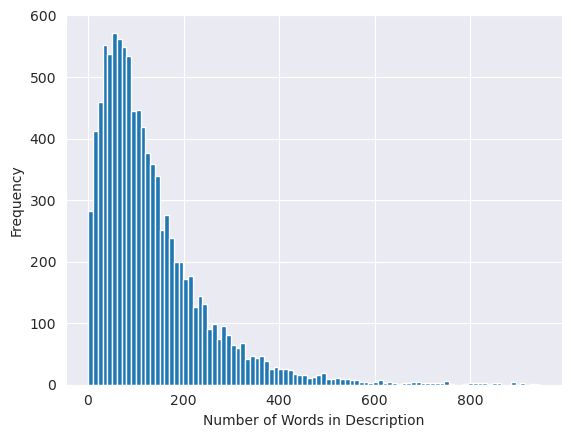

In [9]:
#add a column for the word count
df_review['word_count'] = df_review['text'].apply(lambda x: len(str(x).split(" ")))
print("Word Count Median: " + str(df_review['word_count'].median()))
print(df_review['word_count'].describe())
x = df_review['word_count']
n_bins = 95
plt.hist(x, bins=n_bins)
plt.xlabel('Number of Words in Description')
plt.ylabel('Frequency')
plt.show()

In [10]:
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

#create a list of stop words
stop_words = set(stopwords.words("english"))#show how many words are in the list of stop words
print(len(stop_words))
#179#construct a new list to store the cleaned text
clean_desc = []
for w in range(len(df_review.text)):
    desc = df_review['text'][w].lower()

    #remove punctuation
    desc = re.sub('[^a-zA-Z]', ' ', desc)

    #remove tags
    desc = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)

    #remove special characters and digits
    desc = re.sub("(\\d|\\W)+"," ",desc)

    split_text = desc.split()

    #Lemmatisation
    lem = WordNetLemmatizer()
    split_text = [lem.lemmatize(word) for word in split_text if not word in stop_words and len(word) >2]
    split_text = " ".join(split_text)
    clean_desc.append(split_text)

179


In [11]:
#TF-IDF vectorizer
tfv = TfidfVectorizer(stop_words = stop_words, ngram_range = (1,1))#transform
vec_text = tfv.fit_transform(clean_desc)#returns a list of words.
words = tfv.get_feature_names()

print(vec_text)
print(words)

  (0, 1507)	0.05711499038527128
  (0, 23942)	0.07842532580856981
  (0, 874)	0.1099957153466189
  (0, 22444)	0.1234402538397897
  (0, 4552)	0.13024054137937982
  (0, 13590)	0.07756692946661617
  (0, 54)	0.10479145608504943
  (0, 2650)	0.08903827749507219
  (0, 9633)	0.20503232063843177
  (0, 16312)	0.10314180156063021
  (0, 3191)	0.07598473145683622
  (0, 5863)	0.0734916979067327
  (0, 21894)	0.08342351887216197
  (0, 20003)	0.1624516074428533
  (0, 23638)	0.11860484095795315
  (0, 7067)	0.10022081909695238
  (0, 19234)	0.16650277336346914
  (0, 22853)	0.14931633043343429
  (0, 24268)	0.1029256570007172
  (0, 12888)	0.0829330442460176
  (0, 13721)	0.07011287972744612
  (0, 7592)	0.07830073906162796
  (0, 657)	0.1578609249983263
  (0, 15321)	0.07136915176104107
  (0, 8752)	0.07694918378901457
  :	:
  (9999, 22532)	0.10917086951491574
  (9999, 15297)	0.11908333175421659
  (9999, 7959)	0.11755820683066043
  (9999, 8027)	0.09771158912987316
  (9999, 22226)	0.17349499895017476
  (9999, 3903)

/home/hugo/anaconda3/envs/env3.10/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
X = vec_text.toarray()
#X=pd.DataFrame(X)
#X=np.array(X, dtype=object)
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
from sklearn.decomposition import PCA

#Antes de aplicar el método de clasificación utilizamos PCA para reducir el número de atributos
print('Dim originally: ',X.shape)
#Como vamos a representar gráficamente los clusters, nos quedaremos con los 2 atributos más imporantes
pca = PCA(n_components=10)
pca.fit(X)
# Cambio de base a dos dimensiones PCA
X = pca.transform(X)
print('Dim after PCA: ',X.shape)
print(X)


Dim originally:  (10000, 24913)
Dim after PCA:  (10000, 10)
[[ 1.54542920e-02 -6.31156250e-02 -1.85721868e-02 ... -4.82363711e-02
  -2.41245788e-02 -2.95794992e-02]
 [ 3.43926014e-03 -1.56257775e-01  1.90449206e-01 ... -5.78879144e-02
   2.00817792e-02 -3.89853134e-02]
 [ 1.84244684e-02  2.41703414e-02  3.89851002e-04 ...  6.46014494e-02
  -1.76122994e-04  5.91810221e-02]
 ...
 [ 3.43314796e-02 -1.02262232e-02 -1.60945231e-02 ... -4.71907864e-02
  -5.36190456e-02  2.02019128e-02]
 [-9.55741529e-02  3.05017564e-02 -1.35321274e-02 ...  1.67371591e-02
  -1.09393650e-02 -4.21903488e-02]
 [ 9.58679261e-03 -3.37730279e-02  2.05138163e-01 ... -1.39924203e-02
  -1.75274789e-02 -2.14832617e-02]]


In [43]:
class Distance_computation_grid(object):

    def __init__(self):
        pass

    def compute_distance(self,samples):

        Distance_mat = np.zeros((len(samples),len(samples))) #Hace una matriz de 10000*10000
        for i in range(Distance_mat.shape[0]):
            for j in range(Distance_mat.shape[0]):
                if i!=j:#Solo calcula distancias en una mitad de la matriz
                    Distance_mat[i,j] = float(self.distance_calculate(samples[i],samples[j])) #Para cada pos en la matriz calcula las distancias

                else:
                    Distance_mat[i,j] = 10**4 #Pone un valor muy grande
        return Distance_mat

    def distance_calculate(self,sample1,sample2):

        dist = []
        for i in range(len(sample1)):
            for j in range(len(sample2)):
                    dist.append(abs(sample1[i][0]-sample2[j][0])+abs(sample1[i][1]-sample2[j][1]))
        return np.min(dist)

    def intersampledist(self,s1,s2):
        if str(type(s2[0]))!='<class \'list\'>':
            s2=[s2]
        if str(type(s1[0]))!='<class \'list\'>':
            s1=[s1]
        m = len(s1)
        n = len(s2)
        dist = []
        if n>=m:
            for i in range(n):
                for j in range(m):
                    if (len(s2[i])>=len(s1[j])) and str(type(s2[i][0])!='<class \'list\'>'):
                        dist.append(self.interclusterdist(s2[i],s1[j]))
                    else:
                        dist.append(abs(s1[i][0]-s2[j][0])+abs(s1[i][1]-s2[j][1]))
        else:
            for i in range(m):
                for j in range(n):
                    if (len(s1[i])>=len(s2[j])) and str(type(s1[i][0])!='<class \'list\'>'):
                        dist.append(self.interclusterdist(s1[i],s2[j]))
                    else:
                        dist.append(abs(s1[i][0]-s2[j][0])+abs(s1[i][1]-s2[j][1]))
        return min(dist)

    def centroide(self,sample):
        if(len(sample) == 1):
            return np.mean()
        else:
            sample1=sample[0]
            i=1
            while i < len(sample):
                dist.append(abs(s1[i][0]-s2[j][0])+abs(s1[i][1]-s2[j][1]))

        return np.mean(dist)

    def interclusterdist(self,cl,sample):
        if sample[0]!='<class \'list\'>':
            sample = [sample]
        dist   = []
        for i in range(len(cl)):
            for j in range(len(sample)):
                dist.append(np.linalg.norm(np.array(cl[i])-np.array(sample[j])))
        return min(dist)

In [44]:
dist = []
print(X[0])
print(X[1])
print((np.array(X[0])-np.array(X[1])))
dist.append(abs(X[0][0]-X[1][0])+abs(X[0][1]-X[1][1]))
print(dist)

[ 0.01552378 -0.06312095]
[ 0.00315856 -0.15643833]
[0.01236522 0.09331738]
[0.10568260492987452]


In [45]:
progression = [[i] for i in range(X.shape[0])]
samples     = [[list(X[i])] for i in range(X.shape[0])]
m = len(samples)
distcal  = Distance_computation_grid()

print('Sample size before clustering    :- ',m)
Distance_mat      = distcal.compute_distance(samples)
print(Distance_mat)
dist_mat = pd.DataFrame(Distance_mat)

Sample size before clustering    :-  10000
[[1.00000000e+04 1.05682605e-01 9.07108986e-02 ... 7.20782926e-02
  2.04902930e-01 3.53416145e-02]
 [1.05682605e-01 1.00000000e+04 1.96393503e-01 ... 1.77760897e-01
  2.85855092e-01 1.28892449e-01]
 [9.07108986e-02 1.96393503e-01 1.00000000e+04 ... 5.02021457e-02
  1.20387486e-01 6.75010546e-02]
 ...
 [7.20782926e-02 1.77760897e-01 5.02021457e-02 ... 1.00000000e+04
  1.70589632e-01 4.88684486e-02]
 [2.04902930e-01 2.85855092e-01 1.20387486e-01 ... 1.70589632e-01
  1.00000000e+04 1.69561315e-01]
 [3.53416145e-02 1.28892449e-01 6.75010546e-02 ... 4.88684486e-02
  1.69561315e-01 1.00000000e+04]]


In [46]:

def buscarMin(matrizDistancias):
    columnas=0
    filas=0
    x= 0
    y=0
    min =1000000000000000000000000000000000000000000
    columnas=len(matrizDistancias)
    filas=len(matrizDistancias)

    for i in range(0,len(matrizDistancias)-1):
        for j in range(0,len(matrizDistancias)-1):
            if matrizDistancias[i][j] < min:
                x=i
                y=j
                min = matrizDistancias[i][j]

    return x,y, min

print(dist_mat.min().min())

0.0


In [ ]:
print('se han calculado las distancias')
sample_ind_needed = np.where(Distance_mat==Distance_mat.min())[0]
value_to_add      = samples.pop(sample_ind_needed[1])
samples[sample_ind_needed[0]].append(value_to_add)

print('Cluster Node 1                   :-',progression[sample_ind_needed[0]])
print('Cluster Node 2                   :-',progression[sample_ind_needed[1]])

progression[sample_ind_needed[0]].append(progression[sample_ind_needed[1]])
progression[sample_ind_needed[0]] = [progression[sample_ind_needed[0]]]
v = progression.pop(sample_ind_needed[1])
m = len(samples)

print('Progression(Current Sample)      :-',progression)
print('Cluster attained                 :-',progression[sample_ind_needed[0]])
print('Sample size after clustering     :-',m)
print('\n')


In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
def hierarchical_clustering(data,linkage,no_of_clusters):
    #first step is to calculate the initial distance matrix
    #it consists distances from all the point to all the point
    color = ['r','g','b','y','c','m','k','w']
    initial_distances = pairwise_distances(data,metric='euclidean')
    #making all the diagonal elements infinity
    np.fill_diagonal(initial_distances,sys.maxsize)
    clusters = find_clusters(initial_distances,linkage)

    #plotting the clusters
    iteration_number = initial_distances.shape[0] - no_of_clusters
    clusters_to_plot = clusters[iteration_number]
    arr = np.unique(clusters_to_plot)

    indices_to_plot = []
    fig = plt.figure()
    fig.suptitle('Scatter Plot for clusters')
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    for x in np.nditer(arr):
        indices_to_plot.append(np.where(clusters_to_plot==x))
    p=0

    print(clusters_to_plot)
    for i in range(0,len(indices_to_plot)):
        for j in np.nditer(indices_to_plot[i]):
               ax.scatter(data[j,0],data[j,1], c= color[p])
        p = p + 1

    plt.show()


def find_clusters(input,linkage):
    clusters = {}
    row_index = -1
    col_index = -1
    array = []


    for n in range(input.shape[0]):
        array.append(n)

    clusters[0] = array.copy()

    #finding minimum value from the distance matrix
    #note that this loop will always return minimum value from bottom triangle of matrix
    for k in range(1, input.shape[0]):
        min_val = sys.maxsize

        for i in range(0, input.shape[0]):
            for j in range(0, input.shape[1]):
                if(input[i][j]<=min_val):
                    min_val = input[i][j]
                    row_index = i
                    col_index = j

        #once we find the minimum value, we need to update the distance matrix
        #updating the matrix by calculating the new distances from the cluster to all points

        #for Single Linkage
        if(linkage == "single" or linkage =="Single"):
            for i in range(0,input.shape[0]):
                if(i != col_index):
                    #we calculate the distance of every data point from newly formed cluster and update the matrix.
                    temp = min(input[col_index][i],input[row_index][i])
                    #we update the matrix symmetrically as our distance matrix should always be symmetric
                    input[col_index][i] = temp
                    input[i][col_index] = temp
        #for Complete Linkage
        elif(linkage=="Complete" or linkage == "complete"):
             for i in range(0,input.shape[0]):
                if(i != col_index and i!=row_index):
                    temp = min(input[col_index][i],input[row_index][i])
                    input[col_index][i] = temp
                    input[i][col_index] = temp
        #for Average Linkage
        elif(linkage=="Average" or linkage == "average"):
             for i in range(0,input.shape[0]):
                if(i != col_index and i!=row_index):
                    temp = (input[col_index][i]+input[row_index][i])/2
                    input[col_index][i] = temp
                    input[i][col_index] = temp

        elif(linkage=="Centroid" or linkage =="centroid"):
            for i in range(0,input.shape[0]):
                if(i!=col_index and i!=row_index):
                    dist_centroid = cal_dist_from_centroid(i,row_index,col_index)
                    input[col_index][i] = dist_centroid
                    input[i][col_index] = dist_centroid

        #set the rows and columns for the cluster with higher index i.e. the row index to infinity
        #Set input[row_index][for_all_i] = infinity
        #set input[for_all_i][row_index] = infinity
        for i in range (0,input.shape[0]):
            input[row_index][i] = sys.maxsize
            input[i][row_index] = sys.maxsize

        #Manipulating the dictionary to keep track of cluster formation in each step
        #if k=0,then all datapoints are clusters

        minimum = min(row_index,col_index)
        maximum = max(row_index,col_index)
        for n in range(len(array)):
            if(array[n]==maximum):
                array[n] = minimum
        clusters[k] = array.copy()

    return clusters
clusters = hierarchical_clustering(X,1,2)
print(clusters)

In [ ]:
# Import the f
print(clusters)

In [ ]:
cluster and linkage functions
from scipy.cluster.hierarchy import fcluster, linkage

# Use the linkage() function
distance_matrix = linkage(X, method = 'ward', metric = 'euclidean')

In [ ]:
# Import the dendrogram function
from scipy.cluster.hierarchy import dendrogram

# Create a dendrogram
dn = dendrogram(distance_matrix)

# Display the dendogram
plt.show()